<a href="https://colab.research.google.com/github/yastika/myColabProjects/blob/main/GWP_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
start_date = '2019-01-01'
end_date = '2024-01-01'

In [ ]:
nifty_50 = yf.download('^NSEI', start=start_date, end=end_date)
nifty_50.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,10868.849609,10895.349609,10735.049805,10792.500000,10792.500000,309700
2019-01-03,10796.799805,10814.049805,10661.250000,10672.250000,10672.250000,286200
2019-01-04,10699.700195,10741.049805,10628.650391,10727.349609,10727.349609,296600
2019-01-07,10804.849609,10835.950195,10750.150391,10771.799805,10771.799805,269400
2019-01-08,10786.250000,10818.450195,10733.250000,10802.150391,10802.150391,277700


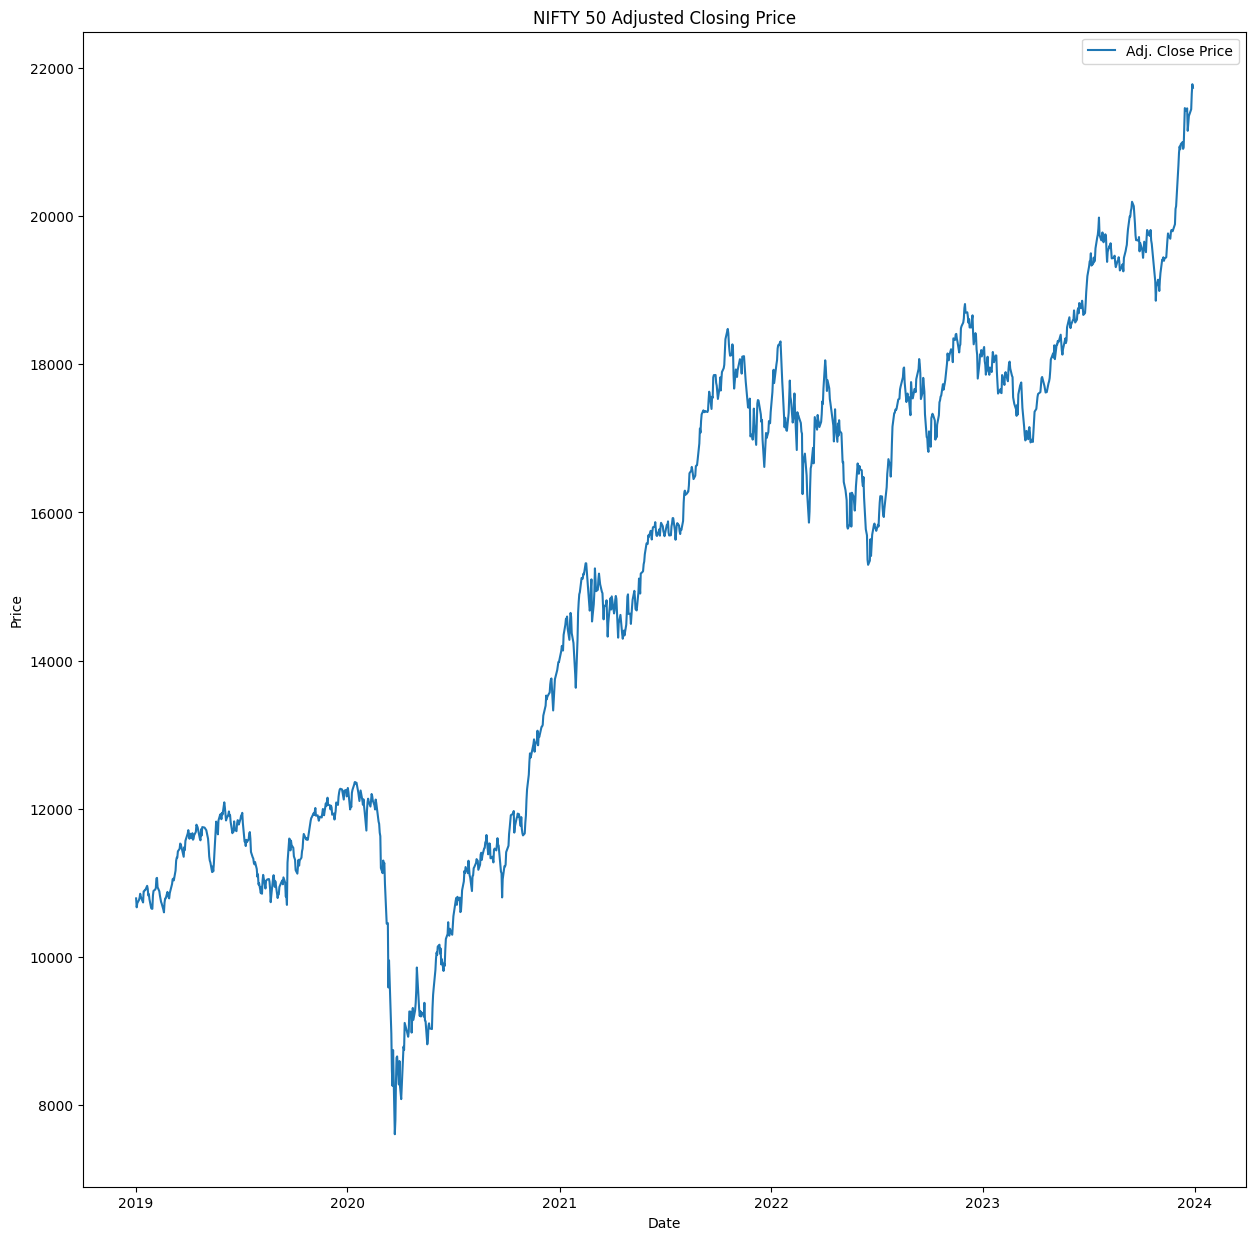

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(nifty_50['Adj Close'], label='Adj. Close Price')
plt.title('NIFTY 50 Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
nifty_50 = np.log(nifty_50)
nifty_50 = nifty_50.replace([np.inf, -np.inf], np.nan).dropna()
nifty_50.drop(['Close','Volume'], axis=1, inplace=True)
nifty_50.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,Open,High,Low,Adj Close
Date,,,,
2019-01-02,9.293656,9.296091,9.281269,9.286607
2019-01-03,9.287005,9.288601,9.274371,9.275402
2019-01-04,9.277971,9.281828,9.271309,9.280552
2019-01-07,9.287750,9.290625,9.282675,9.284687
2019-01-08,9.286027,9.289008,9.281102,9.287501


In [ ]:
from sklearn.model_selection import train_test_split

X,y = nifty_50.iloc[:,:-1], nifty_50.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)
hyper_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4, 5, 6]}


In [ ]:
%pip install bayesian-optimization==1.4.1

Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388


In [ ]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

pbounds = {'kernel': (0,3), 'C': (0.01, 100)}
kernel_mapping = {0: 'linear', 1: 'poly', 2: 'rbf', 3: 'sigmoid'}


def stratified_kfold_score(clf, X_train, y_train, n_fold):
    X, y = X_train, y_train
    strat_kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = mean_absolute_error(preds, y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

def bo_params_rf(kernel, C, degree):
    params = {
         "kernel": kernel_mapping[int(kernel)],
        "C": C,
        "degree":int(degree)
    }
    clf = svm.SVR(
        kernel=params["kernel"],
        C=params["C"],
        degree = params["degree"]
    )
    score = stratified_kfold_score(clf, X_train, y_train, 5)
    return score

In [ ]:
int( 5.9302133200625654)

5

In [ ]:
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn import svm
import time

start = time.process_time()

# Define the parameter space with 'degree' as a discrete parameter
pbounds = {'kernel': (0,3), 'C': (0.01, 100)}
ptypes = {'kernel': 'categorical', 'C': 'continuous', 'degree': 'discrete'}

optimizer = BayesianOptimization(
    bo_params_rf, {'kernel': (0,3), 'C': (0.01, 100), 'degree':(2,6)}
)
end_time = time.process_time() - start

In [ ]:
utility = UtilityFunction(kind='ucb', kappa=2.5, xi=0.0)
# 'n_iter' is a parameter for the optimization process, not the Gaussian Process
#optimizer.set_gp_params()
results = optimizer.maximize(n_iter=200, init_points=20,  acq="ei")
print(results)
#results = rf_bo.maximize(n_iter=200, init_points=20, acq="ei")

|   iter    |  target   |     C     |  degree   |  kernel   |
-------------------------------------------------------------
| 1         | 0.05493   | 55.58     | 5.943     | 2.406     |
| 2         | 0.05493   | 28.82     | 2.42      | 2.019     |
| 3         | 0.04423   | 97.85     | 4.478     | 0.3891    |
| 4         | 0.04423   | 2.012     | 5.043     | 0.8107    |
| 5         | 0.05551   | 50.23     | 5.848     | 1.598     |
| 6         | 0.05493   | 64.21     | 2.941     | 2.908     |
| 7         | 0.05493   | 83.43     | 2.308     | 2.83      |


<ipython-input-11-081bc198a688>:4: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  results = optimizer.maximize(n_iter=200, init_points=20,  acq="ei")


| 8         | 0.04423   | 87.69     | 4.968     | 0.3284    |
| 9         | 0.04745   | 67.12     | 2.326     | 1.724     |
| 10        | 0.05274   | 87.33     | 4.916     | 1.237     |
| 11        | 0.05493   | 18.11     | 5.542     | 2.813     |
| 12        | 0.04423   | 18.56     | 5.784     | 0.05765   |
| 13        | 0.05493   | 62.27     | 5.849     | 2.804     |
| 14        | 0.04423   | 30.49     | 3.031     | 0.927     |
| 15        | 0.05493   | 60.29     | 4.798     | 2.862     |
| 16        | 0.05011   | 82.06     | 3.088     | 1.984     |
| 17        | 0.05551   | 56.57     | 5.442     | 1.422     |
| 18        | 0.04423   | 33.07     | 2.041     | 0.1507    |
| 19        | 0.05493   | 6.23      | 3.266     | 2.435     |
| 20        | 0.05493   | 96.85     | 4.263     | 2.27      |
| 21        | 0.05493   | 83.43     | 2.356     | 2.835     |
| 22        | 0.05493   | 55.98     | 4.845     | 2.147     |
| 23        | 0.05493   | 57.09     | 5.445     | 2.628     |
| 24    

In [ ]:
print(optimizer.max)

{'target': 0.19550228026193966, 'params': {'C': 63.9230632444493, 'degree': 4.7612332121363, 'kernel': 3.0}}


In [ ]:
regressor_BS = svm.SVR(kernel='sigmoid', C=4, degree=5)
regressor_BS.fit(X_train, y_train)

SVR(C=4, degree=5, kernel='sigmoid')

In [ ]:
from sklearn.metrics import mean_squared_error
y_predict = regressor_BS.predict(X_test)
y_fitted = regressor_BS.predict(X_train) #to plot graph
mean_squared_error(y_test, y_predict)

0.11789656127910976

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.DataFrame(cancer.target, columns=['Cancer'])

import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=42)

#!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real
C = Real(0.1, 10000)
gamma = Real(1e-6, 1e+1,'log-uniform')
opt = BayesSearchCV(SVC(), {
        'C': Real(0.1, 10000),
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'), },
                    cv = 5,
   n_iter=20,
    verbose = 3,
   random_state=42)
_ = opt.fit(X_train, y_train)
print(opt.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=4101.098578137254, gamma=0.1241881627783703;, score=0.625 total time=   0.0s
[CV 2/5] END C=4101.098578137254, gamma=0.1241881627783703;, score=0.625 total time=   0.0s
[CV 3/5] END C=4101.098578137254, gamma=0.1241881627783703;, score=0.625 total time=   0.0s
[CV 4/5] END C=4101.098578137254, gamma=0.1241881627783703;, score=0.633 total time=   0.0s
[CV 5/5] END C=4101.098578137254, gamma=0.1241881627783703;, score=0.620 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=8373.899816697289, gamma=1.5247791391944723;, score=0.625 total time=   0.0s
[CV 2/5] END C=8373.899816697289, gamma=1.5247791391944723;, score=0.625 total time=   0.0s
[CV 3/5] END C=8373.899816697289, gamma=1.5247791391944723;, score=0.625 total time=   0.0s
[CV 4/5] END C=8373.899816697289, gamma=1.5247791391944723;, score=0.633 total time=   0.0s
[CV 5/5] END C=8373.899816697289, gamma=1.524779139194

In [ ]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
start = time.process_time()


grid = GridSearchCV(svm.SVR(), hyper_params, refit=True, verbose=3, cv=5)

# fitting the model for grid search
grid.fit(X_train, y_train)
grid_search_time = time.process_time() - start

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..C=0.01, degree=2, kernel=linear;, score=-0.468 total time=   0.0s
[CV 2/5] END ...C=0.01, degree=2, kernel=linear;, score=0.127 total time=   0.0s
[CV 3/5] END ...C=0.01, degree=2, kernel=linear;, score=0.906 total time=   0.0s
[CV 4/5] END ..C=0.01, degree=2, kernel=linear;, score=-1.728 total time=   0.0s
[CV 5/5] END ..C=0.01, degree=2, kernel=linear;, score=-2.040 total time=   0.0s
[CV 1/5] END .....C=0.01, degree=2, kernel=poly;, score=0.858 total time=   0.0s
[CV 2/5] END .....C=0.01, degree=2, kernel=poly;, score=0.303 total time=   0.0s
[CV 3/5] END .....C=0.01, degree=2, kernel=poly;, score=0.823 total time=   0.0s
[CV 4/5] END ....C=0.01, degree=2, kernel=poly;, score=-1.780 total time=   0.0s
[CV 5/5] END ....C=0.01, degree=2, kernel=poly;, score=-1.649 total time=   0.0s
[CV 1/5] END .....C=0.01, degree=2, kernel=rbf;, score=-1.443 total time=   0.0s
[CV 2/5] END .....C=0.01, degree=2, kernel=rbf

In [ ]:
start = time.process_time()
rand_search = RandomizedSearchCV(svm.SVR(), hyper_params, refit=True, verbose=3, cv=5)

# fitting the model for random search
rand_search.fit(X_train, y_train)
rand_search_time = time.process_time() - start

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .......C=1, degree=6, kernel=poly;, score=-0.098 total time=   0.1s
[CV 2/5] END ........C=1, degree=6, kernel=poly;, score=0.223 total time=   0.0s
[CV 3/5] END ........C=1, degree=6, kernel=poly;, score=0.661 total time=   0.0s
[CV 4/5] END .......C=1, degree=6, kernel=poly;, score=-2.062 total time=   0.0s
[CV 5/5] END .......C=1, degree=6, kernel=poly;, score=-1.514 total time=   0.0s
[CV 1/5] END C=0.01, degree=2, kernel=sigmoid;, score=-65.178 total time=   0.1s
[CV 2/5] END .C=0.01, degree=2, kernel=sigmoid;, score=-7.073 total time=   0.1s
[CV 3/5] END .C=0.01, degree=2, kernel=sigmoid;, score=-0.029 total time=   0.1s
[CV 4/5] END C=0.01, degree=2, kernel=sigmoid;, score=-32.814 total time=   0.1s
[CV 5/5] END C=0.01, degree=2, kernel=sigmoid;, score=-32.394 total time=   0.1s
[CV 1/5] END .....C=10, degree=3, kernel=linear;, score=0.942 total time=   0.0s
[CV 2/5] END .....C=10, degree=3, kernel=linear;

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
start = time.process_time()
halve_grid = HalvingGridSearchCV(svm.SVR(), hyper_params, refit=True, verbose=3, cv=5)

# fitting the model for random search
halve_grid.fit(X_train, y_train)
halve_grid_time = time.process_time() - start

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 12
max_resources_: 978
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 12
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=0.01, degree=2, kernel=linear;, score=(train=0.063, test=-76.088) total time=   0.1s
[CV 2/5] END C=0.01, degree=2, kernel=linear;, score=(train=0.026, test=-997.044) total time=   0.1s
[CV 3/5] END C=0.01, degree=2, kernel=linear;, score=(train=0.107, test=-28.170) total time=   0.1s
[CV 4/5] END C=0.01, degree=2, kernel=linear;, score=(train=0.067, test=-555.900) total time=   0.0s
[CV 5/5] END C=0.01, degree=2, kernel=linear;, score=(train=0.083, test=-15.934) total time=   0.1s
[CV 1/5] END C=0.01, degree=2, kernel=poly;, score=(train=0.801, test=-27.025) total time=   0.1s
[CV 2/5] END C=0.01, degree=2, kernel=poly;, score=(train=0.838, test=-998.813) total time=   0.1s
[CV 3/5] END C=0.01, degree=2, kernel=po

In [ ]:
start = time.process_time()
halve_rand_search = HalvingRandomSearchCV(svm.SVR(), hyper_params, refit=True, verbose=3, cv=5)

# fitting the model for random search
halve_rand_search.fit(X_train, y_train)
halve_rand_search_time = time.process_time() - start

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 10
max_resources_: 978
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 97
n_resources: 10
Fitting 5 folds for each of 97 candidates, totalling 485 fits
[CV 1/5] END C=0.01, degree=3, kernel=rbf;, score=(train=0.079, test=-56.225) total time=   0.0s
[CV 2/5] END C=0.01, degree=3, kernel=rbf;, score=(train=0.224, test=-4.414) total time=   0.0s
[CV 3/5] END C=0.01, degree=3, kernel=rbf;, score=(train=0.189, test=-26.877) total time=   0.0s
[CV 4/5] END C=0.01, degree=3, kernel=rbf;, score=(train=0.161, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=3, kernel=rbf;, score=(train=0.168, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=6, kernel=sigmoid;, score=(train=-0.006, test=-57.689) total time=   0.0s
[CV 2/5] END C=0.01, degree=6, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=0.01, degree=6, kernel=sigmoid;, score=(train=-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 2/5] END C=100, degree=3, kernel=linear;, score=(train=0.791, test=-1.414) total time=   0.0s
[CV 3/5] END C=100, degree=3, kernel=linear;, score=(train=0.740, test=-2.092) total time=   0.0s
[CV 4/5] END C=100, degree=3, kernel=linear;, score=(train=0.911, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=3, kernel=linear;, score=(train=0.799, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=5, kernel=linear;, score=(train=0.924, test=0.625) total time=   0.0s
[CV 2/5] END C=10, degree=5, kernel=linear;, score=(train=0.791, test=-1.414) total time=   0.0s
[CV 3/5] END C=10, degree=5, kernel=linear;, score=(train=0.740, test=-2.092) total time=   0.0s
[CV 4/5] END C=10, degree=5, kernel=linear;, score=(train=0.911, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=5, kernel=linear;, score=(train=0.799, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=2, kernel=rbf;, score=(train=0.930, test=-0.231) total time=   0.0s
[CV 2/5] END C=10, degree=2, kernel=rbf;, 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 5/5] END C=100, degree=6, kernel=rbf;, score=(train=0.821, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, kernel=sigmoid;, score=(train=-0.006, test=-57.689) total time=   0.0s
[CV 2/5] END C=1, degree=4, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=1, degree=4, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=1, degree=4, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=4, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=3, kernel=sigmoid;, score=(train=-0.006, test=-57.689) total time=   0.0s
[CV 2/5] END C=0.01, degree=3, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=0.01, degree=3, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=0.01, degree=3, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=0.01

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 5/5] END C=1, degree=2, kernel=rbf;, score=(train=0.821, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=2, kernel=linear;, score=(train=0.924, test=0.625) total time=   0.0s
[CV 2/5] END C=100, degree=2, kernel=linear;, score=(train=0.791, test=-1.414) total time=   0.0s
[CV 3/5] END C=100, degree=2, kernel=linear;, score=(train=0.740, test=-2.092) total time=   0.0s
[CV 4/5] END C=100, degree=2, kernel=linear;, score=(train=0.911, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=2, kernel=linear;, score=(train=0.799, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=3, kernel=rbf;, score=(train=0.930, test=-0.231) total time=   0.0s
[CV 2/5] END C=100, degree=3, kernel=rbf;, score=(train=0.810, test=-3.555) total time=   0.0s
[CV 3/5] END C=100, degree=3, kernel=rbf;, score=(train=0.788, test=-1.345) total time=   0.0s
[CV 4/5] END C=100, degree=3, kernel=rbf;, score=(train=0.933, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=3, kernel=rbf;, score=(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 2/5] END C=0.1, degree=6, kernel=linear;, score=(train=0.369, test=-3.070) total time=   0.0s
[CV 3/5] END C=0.1, degree=6, kernel=linear;, score=(train=0.421, test=-15.902) total time=   0.0s
[CV 4/5] END C=0.1, degree=6, kernel=linear;, score=(train=0.640, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=6, kernel=linear;, score=(train=0.326, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=2, kernel=rbf;, score=(train=0.079, test=-56.225) total time=   0.0s
[CV 2/5] END C=0.01, degree=2, kernel=rbf;, score=(train=0.224, test=-4.414) total time=   0.0s
[CV 3/5] END C=0.01, degree=2, kernel=rbf;, score=(train=0.189, test=-26.877) total time=   0.0s
[CV 4/5] END C=0.01, degree=2, kernel=rbf;, score=(train=0.161, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=2, kernel=rbf;, score=(train=0.168, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=2, kernel=sigmoid;, score=(train=-0.006, test=-57.689) total time=   0.0s
[CV 2/5] END C=1, degree=2, kernel=sig

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 2/5] END C=0.1, degree=4, kernel=poly;, score=(train=0.788, test=-1.486) total time=   0.0s
[CV 3/5] END C=0.1, degree=4, kernel=poly;, score=(train=0.737, test=-1.995) total time=   0.0s
[CV 4/5] END C=0.1, degree=4, kernel=poly;, score=(train=0.906, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=4, kernel=poly;, score=(train=0.803, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=4, kernel=rbf;, score=(train=0.930, test=-0.231) total time=   0.0s
[CV 2/5] END C=100, degree=4, kernel=rbf;, score=(train=0.810, test=-3.555) total time=   0.0s
[CV 3/5] END C=100, degree=4, kernel=rbf;, score=(train=0.788, test=-1.345) total time=   0.0s
[CV 4/5] END C=100, degree=4, kernel=rbf;, score=(train=0.933, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=4, kernel=rbf;, score=(train=0.821, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=6, kernel=poly;, score=(train=0.906, test=0.471) total time=   0.0s
[CV 2/5] END C=100, degree=6, kernel=poly;, score=(train=0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 2/5] END C=10, degree=3, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=10, degree=3, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=10, degree=3, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=3, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=5, kernel=linear;, score=(train=0.054, test=-56.321) total time=   0.0s
[CV 2/5] END C=0.01, degree=5, kernel=linear;, score=(train=0.049, test=-6.327) total time=   0.0s
[CV 3/5] END C=0.01, degree=5, kernel=linear;, score=(train=0.040, test=-34.544) total time=   0.0s
[CV 4/5] END C=0.01, degree=5, kernel=linear;, score=(train=0.093, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=5, kernel=linear;, score=(train=0.054, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=2, kernel=linear;, score=(train=0.924, test=0.625) total time=   0.0s
[CV 2/5] END C=10, deg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 3/5] END C=100, degree=4, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=100, degree=4, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=4, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=5, kernel=poly;, score=(train=0.911, test=0.727) total time=   0.0s
[CV 2/5] END C=0.1, degree=5, kernel=poly;, score=(train=0.786, test=-1.510) total time=   0.0s
[CV 3/5] END C=0.1, degree=5, kernel=poly;, score=(train=0.736, test=-1.965) total time=   0.0s
[CV 4/5] END C=0.1, degree=5, kernel=poly;, score=(train=0.904, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=5, kernel=poly;, score=(train=0.804, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=6, kernel=linear;, score=(train=0.054, test=-56.321) total time=   0.0s
[CV 2/5] END C=0.01, degree=6, kernel=linear;, score=(train=0.049, test=-6.327) total time=   0.0s
[CV 3/5] END C=0.01, degree=6, ke

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 4/5] END C=100, degree=2, kernel=rbf;, score=(train=0.933, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=2, kernel=rbf;, score=(train=0.821, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=5, kernel=sigmoid;, score=(train=-0.006, test=-57.689) total time=   0.0s
[CV 2/5] END C=1, degree=5, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=1, degree=5, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=1, degree=5, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=5, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, kernel=poly;, score=(train=0.915, test=0.875) total time=   0.0s
[CV 2/5] END C=1, degree=4, kernel=poly;, score=(train=0.788, test=-1.486) total time=   0.0s
[CV 3/5] END C=1, degree=4, kernel=poly;, score=(train=0.737, test=-1.995) total time=   0.0s
[CV 4/5] END C=1, degree=4, kernel=poly;, score=(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 5/5] END C=100, degree=5, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=4, kernel=poly;, score=(train=0.915, test=0.875) total time=   0.0s
[CV 2/5] END C=0.01, degree=4, kernel=poly;, score=(train=0.788, test=-1.486) total time=   0.0s
[CV 3/5] END C=0.01, degree=4, kernel=poly;, score=(train=0.737, test=-1.995) total time=   0.0s
[CV 4/5] END C=0.01, degree=4, kernel=poly;, score=(train=0.906, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=4, kernel=poly;, score=(train=0.803, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=5, kernel=poly;, score=(train=0.911, test=0.727) total time=   0.0s
[CV 2/5] END C=0.01, degree=5, kernel=poly;, score=(train=0.786, test=-1.510) total time=   0.0s
[CV 3/5] END C=0.01, degree=5, kernel=poly;, score=(train=0.736, test=-1.965) total time=   0.0s
[CV 4/5] END C=0.01, degree=5, kernel=poly;, score=(train=0.904, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=5, kernel=pol

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 2/5] END C=10, degree=2, kernel=poly;, score=(train=0.790, test=-1.439) total time=   0.0s
[CV 3/5] END C=10, degree=2, kernel=poly;, score=(train=0.739, test=-2.059) total time=   0.0s
[CV 4/5] END C=10, degree=2, kernel=poly;, score=(train=0.910, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=2, kernel=poly;, score=(train=0.800, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=6, kernel=rbf;, score=(train=0.930, test=-0.231) total time=   0.0s
[CV 2/5] END C=10, degree=6, kernel=rbf;, score=(train=0.810, test=-3.555) total time=   0.0s
[CV 3/5] END C=10, degree=6, kernel=rbf;, score=(train=0.788, test=-1.345) total time=   0.0s
[CV 4/5] END C=10, degree=6, kernel=rbf;, score=(train=0.933, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=6, kernel=rbf;, score=(train=0.821, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=4, kernel=poly;, score=(train=0.915, test=0.875) total time=   0.0s
[CV 2/5] END C=100, degree=4, kernel=poly;, score=(train=0.788, tes

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 2/5] END C=10, degree=6, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=10, degree=6, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=10, degree=6, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=6, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=6, kernel=rbf;, score=(train=0.480, test=-40.311) total time=   0.0s
[CV 2/5] END C=0.1, degree=6, kernel=rbf;, score=(train=0.721, test=-3.582) total time=   0.0s
[CV 3/5] END C=0.1, degree=6, kernel=rbf;, score=(train=0.720, test=-3.317) total time=   0.0s
[CV 4/5] END C=0.1, degree=6, kernel=rbf;, score=(train=0.685, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=6, kernel=rbf;, score=(train=0.686, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=6, kernel=poly;, score=(train=0.906, test=0.471) total time=   0.0s
[CV 2/5] END C=10, degree=6, kernel=poly;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 4/5] END C=0.1, degree=3, kernel=linear;, score=(train=0.640, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=3, kernel=linear;, score=(train=0.326, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=5, kernel=linear;, score=(train=0.489, test=-44.767) total time=   0.0s
[CV 2/5] END C=0.1, degree=5, kernel=linear;, score=(train=0.369, test=-3.070) total time=   0.0s
[CV 3/5] END C=0.1, degree=5, kernel=linear;, score=(train=0.421, test=-15.902) total time=   0.0s
[CV 4/5] END C=0.1, degree=5, kernel=linear;, score=(train=0.640, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=5, kernel=linear;, score=(train=0.326, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=2, kernel=poly;, score=(train=0.922, test=0.831) total time=   0.0s
[CV 2/5] END C=0.1, degree=2, kernel=poly;, score=(train=0.790, test=-1.439) total time=   0.0s
[CV 3/5] END C=0.1, degree=2, kernel=poly;, score=(train=0.739, test=-2.059) total time=   0.0s
[CV 4/5] END C=0.1, degree=2, kernel=

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 5/5] END C=0.1, degree=4, kernel=linear;, score=(train=0.326, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, kernel=rbf;, score=(train=0.930, test=-0.231) total time=   0.0s
[CV 2/5] END C=1, degree=4, kernel=rbf;, score=(train=0.810, test=-3.555) total time=   0.0s
[CV 3/5] END C=1, degree=4, kernel=rbf;, score=(train=0.788, test=-1.345) total time=   0.0s
[CV 4/5] END C=1, degree=4, kernel=rbf;, score=(train=0.933, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=4, kernel=rbf;, score=(train=0.821, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=2, kernel=linear;, score=(train=0.924, test=0.625) total time=   0.0s
[CV 2/5] END C=1, degree=2, kernel=linear;, score=(train=0.791, test=-1.414) total time=   0.0s
[CV 3/5] END C=1, degree=2, kernel=linear;, score=(train=0.740, test=-2.092) total time=   0.0s
[CV 4/5] END C=1, degree=2, kernel=linear;, score=(train=0.911, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=2, kernel=linear;, score=(train=0.799, te

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 4/5] END C=1, degree=4, kernel=linear;, score=(train=0.911, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=4, kernel=linear;, score=(train=0.799, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=3, kernel=poly;, score=(train=0.919, test=0.911) total time=   0.0s
[CV 2/5] END C=100, degree=3, kernel=poly;, score=(train=0.789, test=-1.463) total time=   0.0s
[CV 3/5] END C=100, degree=3, kernel=poly;, score=(train=0.738, test=-2.027) total time=   0.0s
[CV 4/5] END C=100, degree=3, kernel=poly;, score=(train=0.908, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=3, kernel=poly;, score=(train=0.802, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=5, kernel=linear;, score=(train=0.924, test=0.625) total time=   0.0s
[CV 2/5] END C=1, degree=5, kernel=linear;, score=(train=0.791, test=-1.414) total time=   0.0s
[CV 3/5] END C=1, degree=5, kernel=linear;, score=(train=0.740, test=-2.092) total time=   0.0s
[CV 4/5] END C=1, degree=5, kernel=linear;, score=(tra

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 1/5] END C=10, degree=4, kernel=rbf;, score=(train=0.930, test=-0.231) total time=   0.0s
[CV 2/5] END C=10, degree=4, kernel=rbf;, score=(train=0.810, test=-3.555) total time=   0.0s
[CV 3/5] END C=10, degree=4, kernel=rbf;, score=(train=0.788, test=-1.345) total time=   0.0s
[CV 4/5] END C=10, degree=4, kernel=rbf;, score=(train=0.933, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=4, kernel=rbf;, score=(train=0.821, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=3, kernel=poly;, score=(train=0.919, test=0.911) total time=   0.0s
[CV 2/5] END C=10, degree=3, kernel=poly;, score=(train=0.789, test=-1.463) total time=   0.0s
[CV 3/5] END C=10, degree=3, kernel=poly;, score=(train=0.738, test=-2.027) total time=   0.0s
[CV 4/5] END C=10, degree=3, kernel=poly;, score=(train=0.908, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=3, kernel=poly;, score=(train=0.802, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=5, kernel=poly;, score=(train=0.911, test=

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 1/5] END C=0.01, degree=6, kernel=poly;, score=(train=0.906, test=0.471) total time=   0.0s
[CV 2/5] END C=0.01, degree=6, kernel=poly;, score=(train=0.785, test=-1.533) total time=   0.0s
[CV 3/5] END C=0.01, degree=6, kernel=poly;, score=(train=0.735, test=-1.935) total time=   0.0s
[CV 4/5] END C=0.01, degree=6, kernel=poly;, score=(train=0.901, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=6, kernel=poly;, score=(train=0.805, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=5, kernel=rbf;, score=(train=0.930, test=-0.231) total time=   0.0s
[CV 2/5] END C=100, degree=5, kernel=rbf;, score=(train=0.810, test=-3.555) total time=   0.0s
[CV 3/5] END C=100, degree=5, kernel=rbf;, score=(train=0.788, test=-1.345) total time=   0.0s
[CV 4/5] END C=100, degree=5, kernel=rbf;, score=(train=0.933, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=5, kernel=rbf;, score=(train=0.821, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=6, kernel=poly;, score=(trai

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 1/5] END C=100, degree=2, kernel=poly;, score=(train=0.922, test=0.831) total time=   0.0s
[CV 2/5] END C=100, degree=2, kernel=poly;, score=(train=0.790, test=-1.439) total time=   0.0s
[CV 3/5] END C=100, degree=2, kernel=poly;, score=(train=0.739, test=-2.059) total time=   0.0s
[CV 4/5] END C=100, degree=2, kernel=poly;, score=(train=0.910, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=2, kernel=poly;, score=(train=0.800, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=4, kernel=sigmoid;, score=(train=-0.006, test=-57.689) total time=   0.0s
[CV 2/5] END C=0.01, degree=4, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=0.01, degree=4, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=0.01, degree=4, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=4, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 2/5] END C=1, degree=2, kernel=poly;, score=(train=0.790, test=-1.439) total time=   0.0s
[CV 3/5] END C=1, degree=2, kernel=poly;, score=(train=0.739, test=-2.059) total time=   0.0s
[CV 4/5] END C=1, degree=2, kernel=poly;, score=(train=0.910, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=2, kernel=poly;, score=(train=0.800, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=4, kernel=linear;, score=(train=0.054, test=-56.321) total time=   0.0s
[CV 2/5] END C=0.01, degree=4, kernel=linear;, score=(train=0.049, test=-6.327) total time=   0.0s
[CV 3/5] END C=0.01, degree=4, kernel=linear;, score=(train=0.040, test=-34.544) total time=   0.0s
[CV 4/5] END C=0.01, degree=4, kernel=linear;, score=(train=0.093, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=4, kernel=linear;, score=(train=0.054, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, degree=3, kernel=linear;, score=(train=0.054, test=-56.321) total time=   0.0s
[CV 2/5] END C=0.01, degree=3, kernel=l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 2/5] END C=1, degree=3, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=1, degree=3, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=1, degree=3, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=3, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=4, kernel=poly;, score=(train=0.915, test=0.875) total time=   0.0s
[CV 2/5] END C=10, degree=4, kernel=poly;, score=(train=0.788, test=-1.486) total time=   0.0s
[CV 3/5] END C=10, degree=4, kernel=poly;, score=(train=0.737, test=-1.995) total time=   0.0s
[CV 4/5] END C=10, degree=4, kernel=poly;, score=(train=0.906, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=4, kernel=poly;, score=(train=0.803, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=3, kernel=poly;, score=(train=0.919, test=0.911) total time=   0.0s
[CV 2/5] END C=0.1, degree=3, kernel=poly;, score=

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 4/5] END C=1, degree=3, kernel=poly;, score=(train=0.908, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=3, kernel=poly;, score=(train=0.802, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=2, kernel=sigmoid;, score=(train=-0.006, test=-57.689) total time=   0.0s
[CV 2/5] END C=100, degree=2, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=100, degree=2, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=100, degree=2, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=2, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=5, kernel=poly;, score=(train=0.911, test=0.727) total time=   0.0s
[CV 2/5] END C=100, degree=5, kernel=poly;, score=(train=0.786, test=-1.510) total time=   0.0s
[CV 3/5] END C=100, degree=5, kernel=poly;, score=(train=0.736, test=-1.965) total time=   0.0s
[CV 4/5] END C=100, degree=5, kerne

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 3/5] END C=1, degree=3, kernel=linear;, score=(train=0.740, test=-2.092) total time=   0.0s
[CV 4/5] END C=1, degree=3, kernel=linear;, score=(train=0.911, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=3, kernel=linear;, score=(train=0.799, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=2, kernel=sigmoid;, score=(train=-0.006, test=-57.689) total time=   0.0s
[CV 2/5] END C=0.1, degree=2, kernel=sigmoid;, score=(train=-0.007, test=-7.009) total time=   0.0s
[CV 3/5] END C=0.1, degree=2, kernel=sigmoid;, score=(train=-0.010, test=-37.040) total time=   0.0s
[CV 4/5] END C=0.1, degree=2, kernel=sigmoid;, score=(train=-0.004, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=2, kernel=sigmoid;, score=(train=-0.001, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=6, kernel=rbf;, score=(train=0.930, test=-0.231) total time=   0.0s
[CV 2/5] END C=1, degree=6, kernel=rbf;, score=(train=0.810, test=-3.555) total time=   0.0s
[CV 3/5] END C=1, degree=6, kernel=r

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 4/5] END C=0.1, degree=4, kernel=rbf;, score=(train=0.685, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=4, kernel=rbf;, score=(train=0.686, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=5, kernel=linear;, score=(train=0.924, test=0.625) total time=   0.0s
[CV 2/5] END C=100, degree=5, kernel=linear;, score=(train=0.791, test=-1.414) total time=   0.0s
[CV 3/5] END C=100, degree=5, kernel=linear;, score=(train=0.740, test=-2.092) total time=   0.0s
[CV 4/5] END C=100, degree=5, kernel=linear;, score=(train=0.911, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=5, kernel=linear;, score=(train=0.799, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=2, kernel=linear;, score=(train=0.489, test=-44.767) total time=   0.0s
[CV 2/5] END C=0.1, degree=2, kernel=linear;, score=(train=0.369, test=-3.070) total time=   0.0s
[CV 3/5] END C=0.1, degree=2, kernel=linear;, score=(train=0.421, test=-15.902) total time=   0.0s
[CV 4/5] END C=0.1, degree=2, kernel=

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

[CV 4/5] END C=0.01, degree=3, kernel=poly;, score=(train=0.908, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, degree=3, kernel=poly;, score=(train=0.802, test=nan) total time=   0.0s
----------
iter: 1
n_candidates: 33
n_resources: 30
Fitting 5 folds for each of 33 candidates, totalling 165 fits
[CV 1/5] END C=10, degree=2, kernel=rbf;, score=(train=0.938, test=0.681) total time=   0.0s
[CV 2/5] END C=10, degree=2, kernel=rbf;, score=(train=0.873, test=-0.982) total time=   0.0s
[CV 3/5] END C=10, degree=2, kernel=rbf;, score=(train=0.906, test=0.837) total time=   0.0s
[CV 4/5] END C=10, degree=2, kernel=rbf;, score=(train=0.942, test=0.050) total time=   0.0s
[CV 5/5] END C=10, degree=2, kernel=rbf;, score=(train=0.938, test=-1.544) total time=   0.0s
[CV 1/5] END C=10, degree=5, kernel=linear;, score=(train=0.925, test=0.852) total time=   0.0s
[CV 2/5] END C=10, degree=5, kernel=linear;, score=(train=0.852, test=0.185) total time=   0.0s
[CV 3/5] END C=10, degree=5, kernel=lin

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  

[CV 1/5] END C=10, degree=3, kernel=rbf;, score=(train=0.908, test=-5.141) total time=   0.0s
[CV 2/5] END C=10, degree=3, kernel=rbf;, score=(train=0.908, test=-2.745) total time=   0.0s
[CV 3/5] END C=10, degree=3, kernel=rbf;, score=(train=0.940, test=0.764) total time=   0.0s
[CV 4/5] END C=10, degree=3, kernel=rbf;, score=(train=0.874, test=-1.267) total time=   0.0s
[CV 5/5] END C=10, degree=3, kernel=rbf;, score=(train=0.905, test=-1.058) total time=   0.0s
[CV 1/5] END C=1, degree=3, kernel=rbf;, score=(train=0.908, test=-5.141) total time=   0.0s
[CV 2/5] END C=1, degree=3, kernel=rbf;, score=(train=0.908, test=-2.745) total time=   0.0s
[CV 3/5] END C=1, degree=3, kernel=rbf;, score=(train=0.940, test=0.764) total time=   0.0s
[CV 4/5] END C=1, degree=3, kernel=rbf;, score=(train=0.874, test=-1.267) total time=   0.0s
[CV 5/5] END C=1, degree=3, kernel=rbf;, score=(train=0.905, test=-1.058) total time=   0.0s
[CV 1/5] END C=10, degree=2, kernel=poly;, score=(train=0.919, test

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  

[CV 5/5] END C=10, degree=2, kernel=poly;, score=(train=0.936, test=-2.362) total time=   0.0s
[CV 1/5] END C=0.01, degree=2, kernel=poly;, score=(train=0.913, test=0.821) total time=   0.0s
[CV 2/5] END C=0.01, degree=2, kernel=poly;, score=(train=0.876, test=0.288) total time=   0.0s
[CV 3/5] END C=0.01, degree=2, kernel=poly;, score=(train=0.933, test=0.802) total time=   0.0s
[CV 4/5] END C=0.01, degree=2, kernel=poly;, score=(train=0.940, test=-1.496) total time=   0.0s
[CV 5/5] END C=0.01, degree=2, kernel=poly;, score=(train=0.936, test=-2.362) total time=   0.0s
----------
iter: 4
n_candidates: 2
n_resources: 810
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END C=10, degree=2, kernel=linear;, score=(train=0.915, test=0.943) total time=   0.0s
[CV 2/5] END C=10, degree=2, kernel=linear;, score=(train=0.880, test=0.309) total time=   0.0s
[CV 3/5] END C=10, degree=2, kernel=linear;, score=(train=0.936, test=0.881) total time=   0.0s
[CV 4/5] END C=10, degr

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'degree': 2, 'kernel': 'linear'}
SVR(C=1, degree=2, kernel='linear')


In [ ]:
# print best parameter after tuning
print(rand_search.best_params_)

# print how our model looks after hyper-parameter tuning
print(rand_search.best_estimator_)

{'kernel': 'linear', 'degree': 3, 'C': 10}
SVR(C=10, kernel='linear')


In [ ]:
# print best parameter after tuning
print(halve_grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(halve_grid.best_estimator_)

{'C': 10, 'degree': 4, 'kernel': 'poly'}
SVR(C=10, degree=4, kernel='poly')


In [ ]:
# print best parameter after tuning
print(halve_rand_search.best_params_)

# print how our model looks after hyper-parameter tuning
print(halve_rand_search.best_estimator_)

{'kernel': 'linear', 'degree': 2, 'C': 10}
SVR(C=10, degree=2, kernel='linear')


In [ ]:
hyper_optimizers = pd.DataFrame(index=['Time','Kernel','degree','C'],columns=['GridSearchCV', 'RandomizedSearchCV', 'HalvingGridSearchCV', 'HalvingRandomSearchCV'])
hyper_optimizers.loc['Time'] = [grid_search_time, rand_search_time, halve_grid_time, halve_rand_search_time]
hyper_optimizers.loc['Kernel'] = [grid.best_params_['kernel'], rand_search.best_params_['kernel'], halve_grid.best_params_['kernel'], halve_rand_search.best_params_['kernel']]
hyper_optimizers.loc['degree'] = [grid.best_params_['degree'], rand_search.best_params_['degree'], halve_grid.best_params_['degree'], halve_rand_search.best_params_['degree']]
hyper_optimizers.loc['C'] = [grid.best_params_['C'], rand_search.best_params_['C'], halve_grid.best_params_['C'], halve_rand_search.best_params_['C']]
hyper_optimizers

,GridSearchCV,RandomizedSearchCV,HalvingGridSearchCV,HalvingRandomSearchCV
Time,7.459917,0.689086,7.612389,7.334077
Kernel,linear,linear,poly,linear
degree,2,3,4,2
C,1,10,10,10


### Financial Forecasting using GridSearch

In [ ]:
regressor_GS = svm.SVR(kernel='linear', C=1, degree=2)
regressor_GS.fit(X_train, y_train)

SVR(C=1, degree=2, kernel='linear')

In [ ]:
from sklearn.metrics import mean_squared_error
y_predict = regressor_GS.predict(X_test)
y_fitted = regressor_GS.predict(X_train) #to plot graph
mean_squared_error(y_test, y_predict)

0.009717418397974525

In [ ]:
test_df = pd.DataFrame(index=y_test.index, data=y_test)
test_df['predicted'] = y_predict
test_df = test_df.sort_index()
test_df.head()

,Adj Close,predicted
Date,,
2022-12-29,9.808682,9.712948
2022-12-30,9.803960,9.717985
2023-01-02,9.809037,9.715482
2023-01-03,9.810964,9.717466
2023-01-04,9.800510,9.716311


In [ ]:
train_df = pd.DataFrame(index=y_train.index, data=y_train)
train_df['Fitted'] = y_fitted
train_df = train_df.sort_index()
train_df.head(10)

,Adj Close,Fitted
Date,,
2019-01-02,9.286607,9.295582
2019-01-03,9.275402,9.289878
2019-01-04,9.280552,9.284808
2019-01-07,9.284687,9.292958
2019-01-08,9.287501,9.291626
2019-01-09,9.292395,9.295198
2019-01-10,9.289299,9.296230
2019-01-11,9.286834,9.293761
2019-01-14,9.281507,9.290808


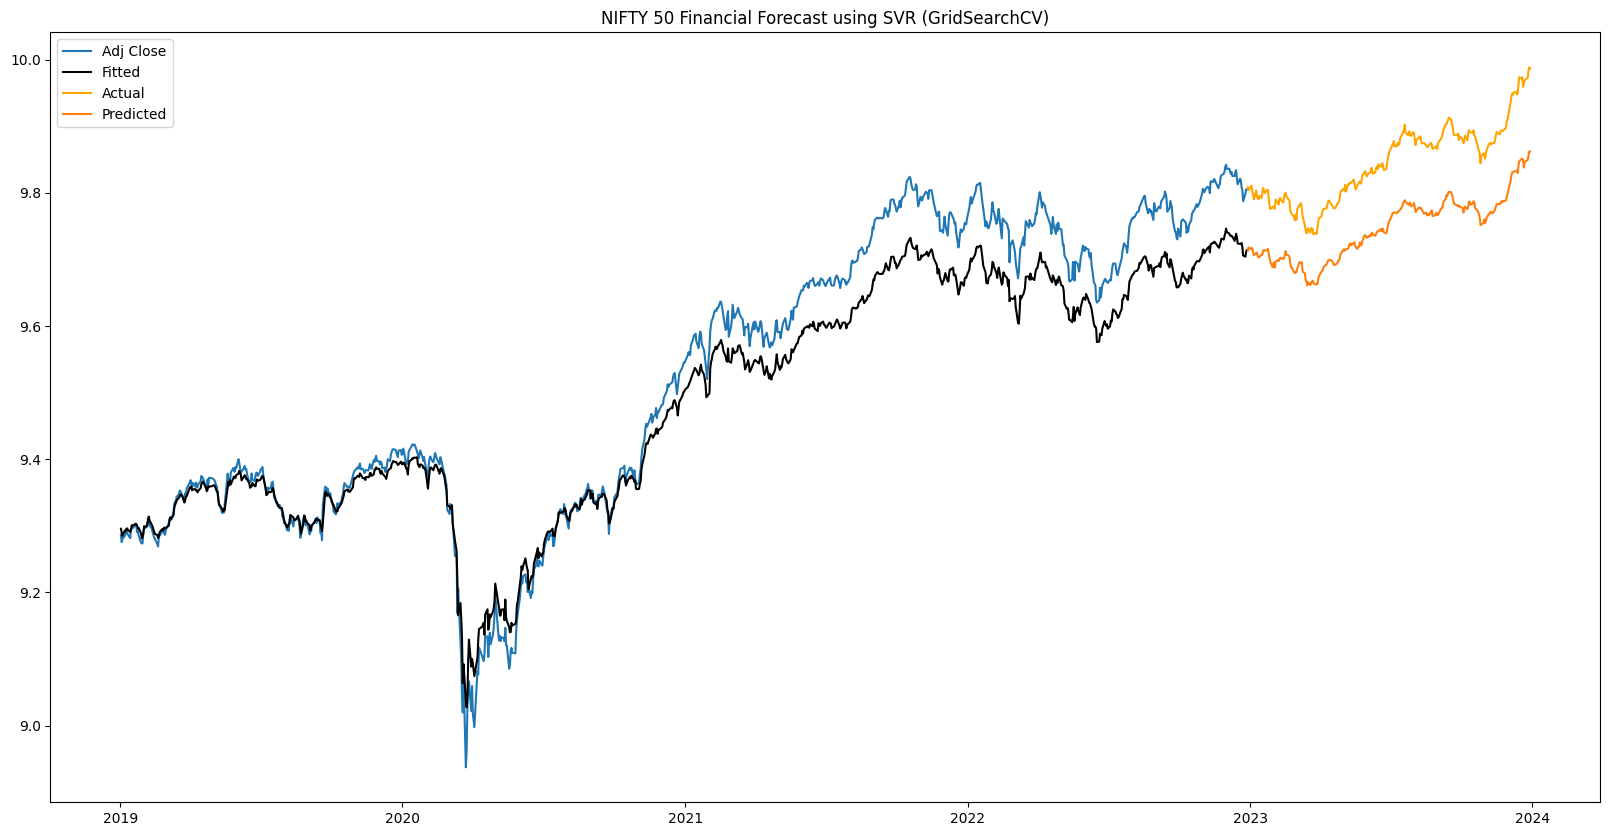

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_df['Adj Close'], label = 'Adj Close')
plt.plot(train_df['Fitted'], label = 'Fitted',color='black')
plt.plot(test_df['Adj Close'],label='Actual', color='orange')
plt.plot(test_df['predicted'],label='Predicted')
plt.title('NIFTY 50 Financial Forecast using SVR (GridSearchCV)')
plt.legend()
plt.show()

### Financial Forecasting using RandomizedSearchCV

In [ ]:
regressor_RS = svm.SVR(kernel='linear', C=1, degree=6)
regressor_RS.fit(X_train, y_train)

SVR(C=1, degree=6, kernel='linear')

In [ ]:
from sklearn.metrics import mean_squared_error
y_predict = regressor_RS.predict(X_test)
y_fitted = regressor_RS.predict(X_train) #to plot graph
mean_squared_error(y_test, y_predict)

0.009717418397974525

In [ ]:
test_df = pd.DataFrame(index=y_test.index, data=y_test)
test_df['predicted'] = y_predict
test_df = test_df.sort_index()
test_df.head()

,Adj Close,predicted
Date,,
2022-12-29,9.808682,9.712948
2022-12-30,9.803960,9.717985
2023-01-02,9.809037,9.715482
2023-01-03,9.810964,9.717466
2023-01-04,9.800510,9.716311


In [ ]:
train_df = pd.DataFrame(index=y_train.index, data=y_train)
train_df['Fitted'] = y_fitted
train_df = train_df.sort_index()
train_df.head(10)

,Adj Close,Fitted
Date,,
2019-01-02,9.286607,9.295582
2019-01-03,9.275402,9.289878
2019-01-04,9.280552,9.284808
2019-01-07,9.284687,9.292958
2019-01-08,9.287501,9.291626
2019-01-09,9.292395,9.295198
2019-01-10,9.289299,9.296230
2019-01-11,9.286834,9.293761
2019-01-14,9.281507,9.290808


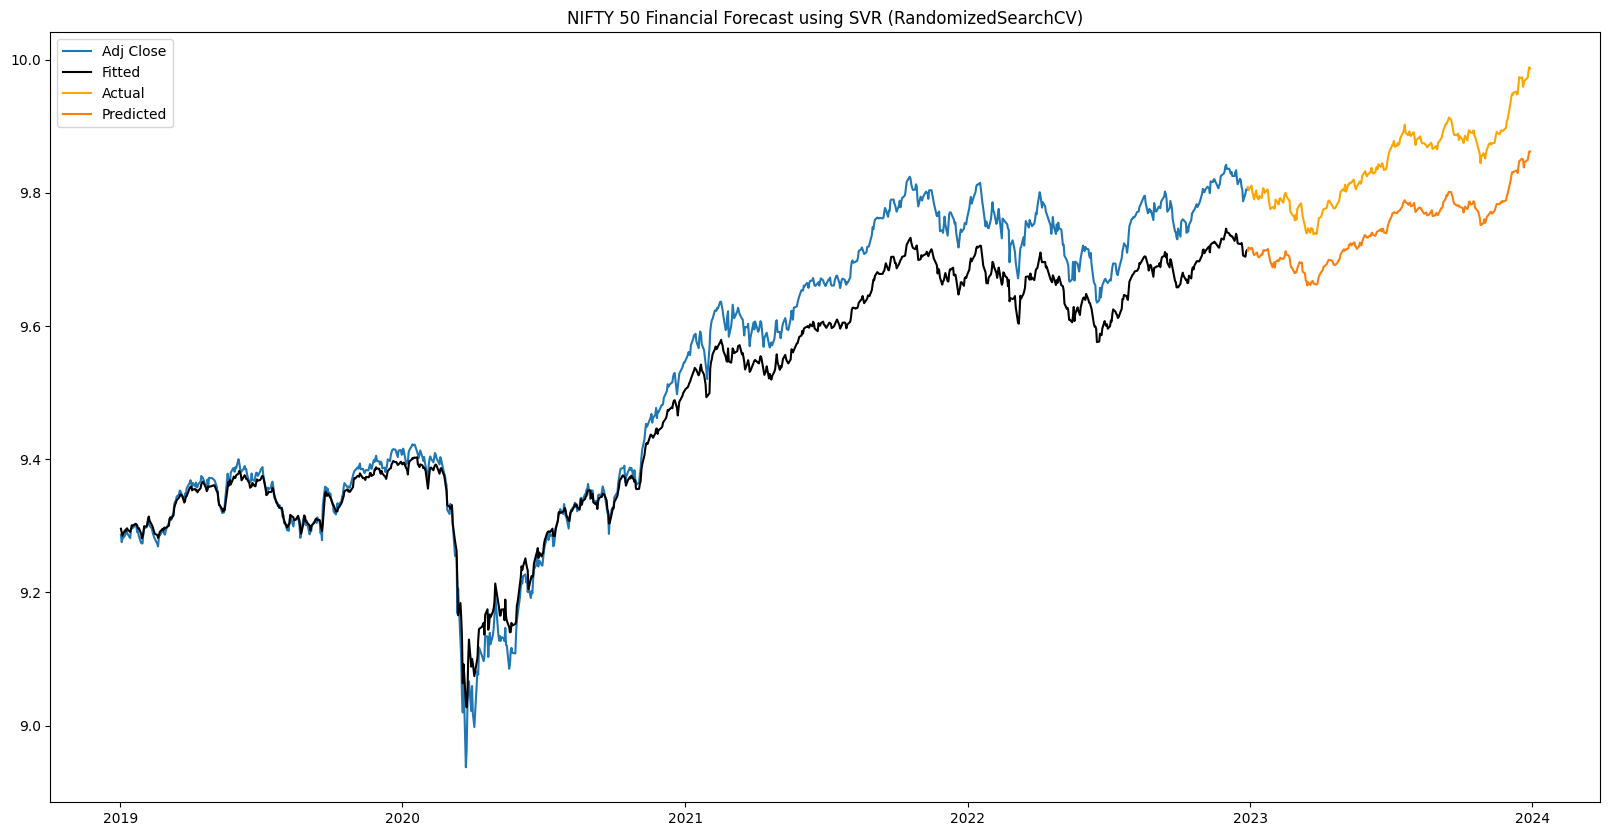

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_df['Adj Close'], label = 'Adj Close')
plt.plot(train_df['Fitted'], label = 'Fitted',color='black')
plt.plot(test_df['Adj Close'],label='Actual', color='orange')
plt.plot(test_df['predicted'],label='Predicted')
plt.title('NIFTY 50 Financial Forecast using SVR (RandomizedSearchCV)')
plt.legend()
plt.show()

### Financial Forecasting using HalvingGridSearchCV

In [ ]:
from sklearn import svm
regressor_HGS = svm.SVR(kernel='poly', C=10, degree=4)
regressor_HGS.fit(X_train, y_train)

SVR(C=10, degree=4, kernel='poly')

In [ ]:
from sklearn.metrics import mean_squared_error
y_predict = regressor_HGS.predict(X_test)
y_fitted = regressor_HGS.predict(X_train) #to plot graph
mean_squared_error(y_test, y_predict)

0.007963817475071936

In [ ]:
test_df = pd.DataFrame(index=y_test.index, data=y_test)
test_df['predicted'] = y_predict
test_df = test_df.sort_index()
test_df.head()

,Adj Close,predicted
Date,,
2022-12-29,9.808682,9.716158
2022-12-30,9.803960,9.721908
2023-01-02,9.809037,9.719001
2023-01-03,9.810964,9.721254
2023-01-04,9.800510,9.720015


In [ ]:
train_df = pd.DataFrame(index=y_train.index, data=y_train)
train_df['Fitted'] = y_fitted
train_df = train_df.sort_index()
train_df.head(10)

,Adj Close,Fitted
Date,,
2019-01-02,9.286607,9.275446
2019-01-03,9.275402,9.269902
2019-01-04,9.280552,9.264948
2019-01-07,9.284687,9.272831
2019-01-08,9.287501,9.271537
2019-01-09,9.292395,9.275042
2019-01-10,9.289299,9.275992
2019-01-11,9.286834,9.273635
2019-01-14,9.281507,9.270774


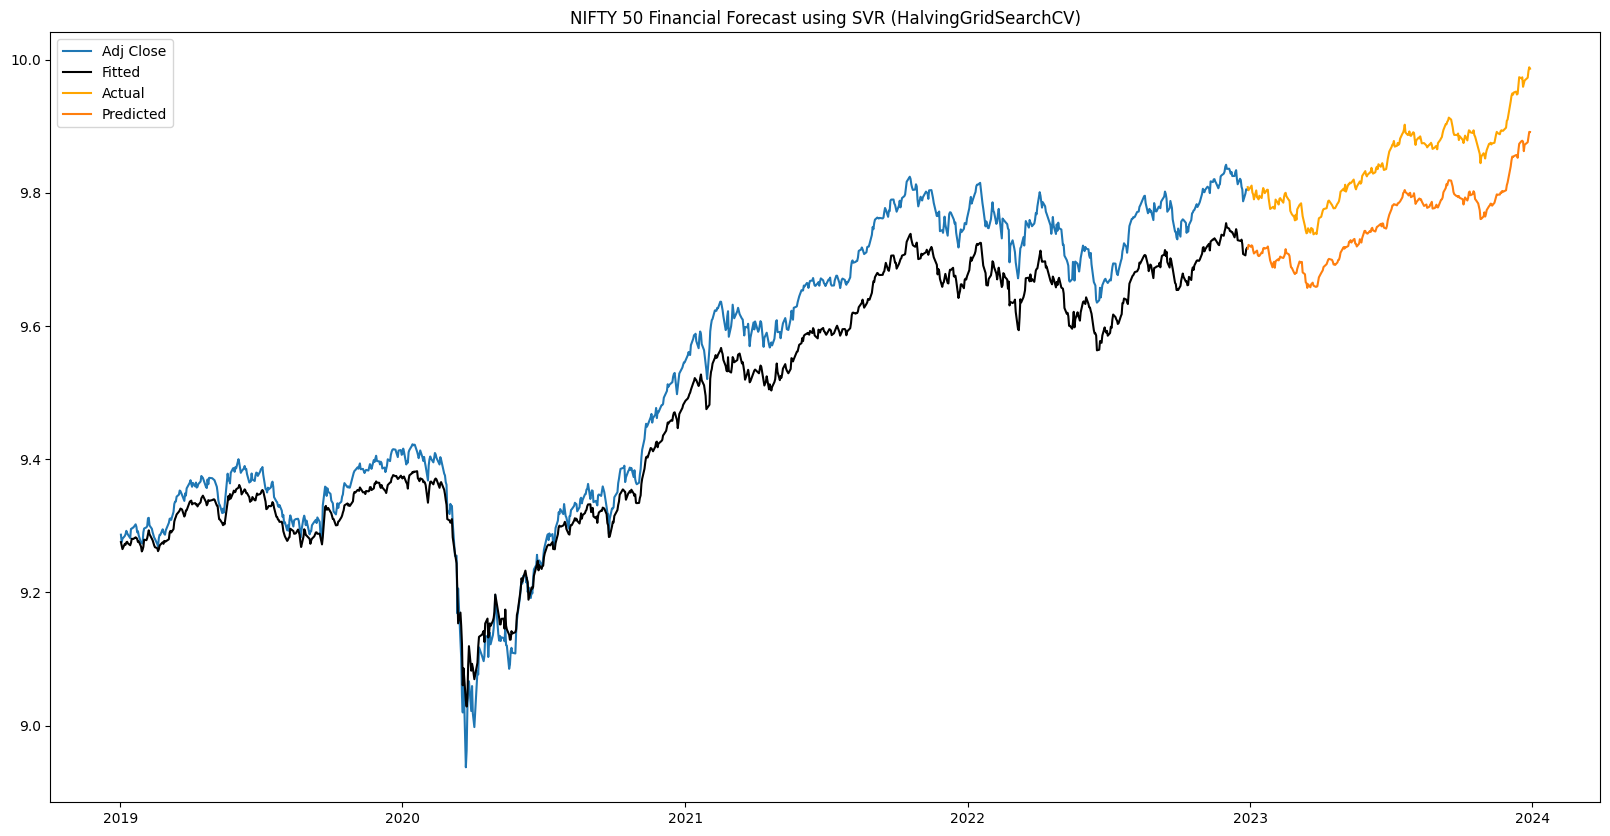

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_df['Adj Close'], label = 'Adj Close')
plt.plot(train_df['Fitted'], label = 'Fitted',color='black')
plt.plot(test_df['Adj Close'],label='Actual', color='orange')
plt.plot(test_df['predicted'],label='Predicted')
plt.title('NIFTY 50 Financial Forecast using SVR (HalvingGridSearchCV)')
plt.legend()
plt.show()

### Financial Forecasting using HalvingRandomizedSearchCV

In [ ]:
regressor_HRS = svm.SVR(kernel='linear', C=100, degree=5)
regressor_HRS.fit(X_train, y_train)

SVR(C=100, degree=5, kernel='linear')

In [ ]:
from sklearn.metrics import mean_squared_error
y_predict = regressor_HRS.predict(X_test)
y_fitted = regressor_HRS.predict(X_train) #to plot graph
mean_squared_error(y_test, y_predict)

0.009717418397974525

In [ ]:
test_df = pd.DataFrame(index=y_test.index, data=y_test)
test_df['predicted'] = y_predict
test_df = test_df.sort_index()
test_df.head()

,Adj Close,predicted
Date,,
2022-12-29,9.808682,9.712948
2022-12-30,9.803960,9.717985
2023-01-02,9.809037,9.715482
2023-01-03,9.810964,9.717466
2023-01-04,9.800510,9.716311


In [ ]:
train_df = pd.DataFrame(index=y_train.index, data=y_train)
train_df['Fitted'] = y_fitted
train_df = train_df.sort_index()
train_df.head(10)

,Adj Close,Fitted
Date,,
2019-01-02,9.286607,9.295582
2019-01-03,9.275402,9.289878
2019-01-04,9.280552,9.284808
2019-01-07,9.284687,9.292958
2019-01-08,9.287501,9.291626
2019-01-09,9.292395,9.295198
2019-01-10,9.289299,9.296230
2019-01-11,9.286834,9.293761
2019-01-14,9.281507,9.290808


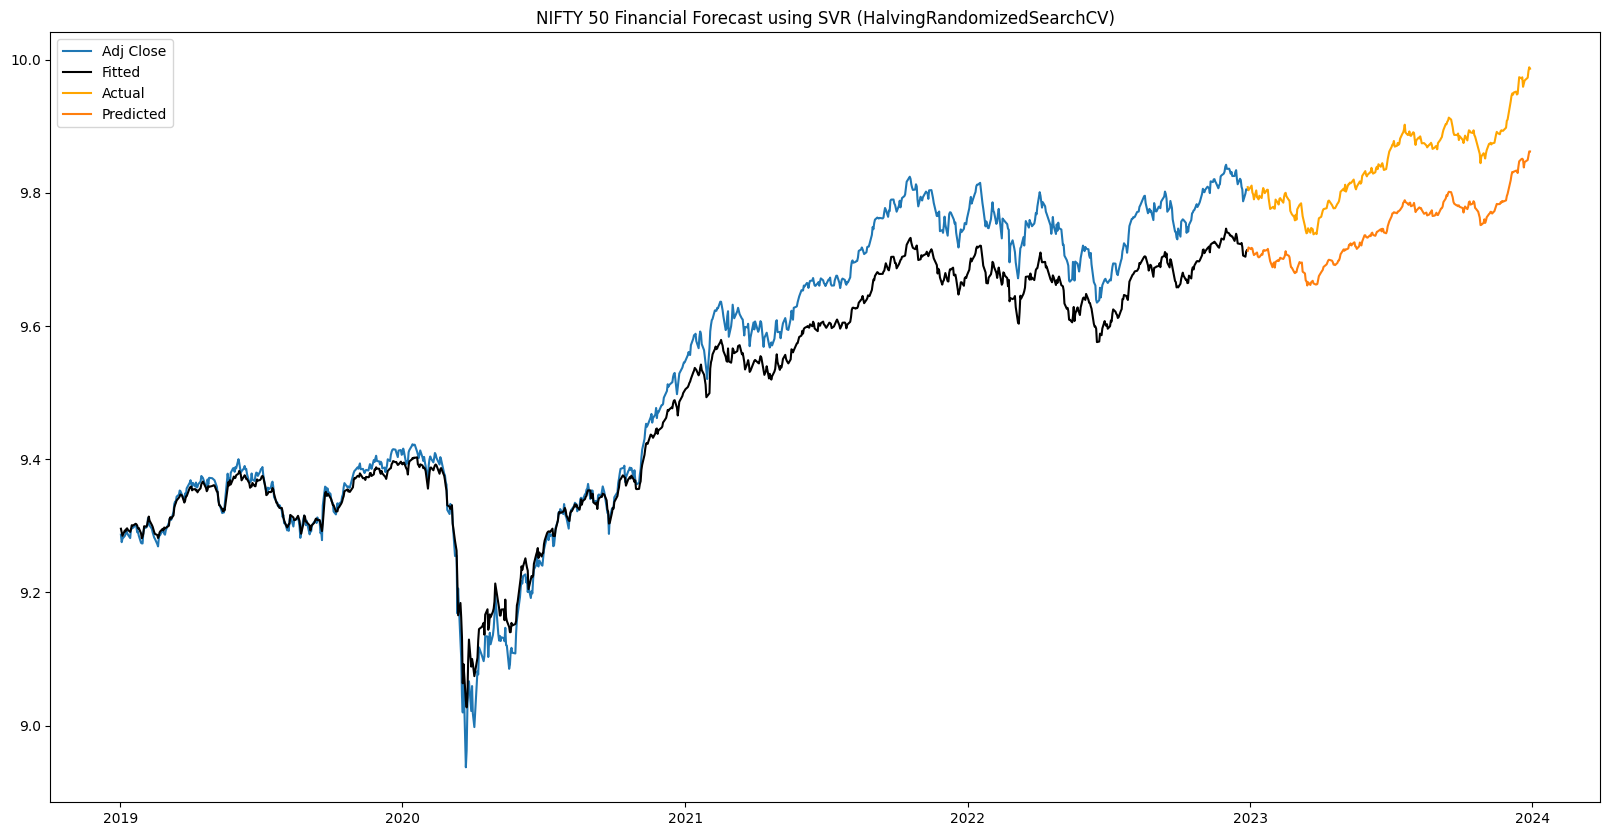

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_df['Adj Close'], label = 'Adj Close')
plt.plot(train_df['Fitted'], label = 'Fitted',color='black')
plt.plot(test_df['Adj Close'],label='Actual', color='orange')
plt.plot(test_df['predicted'],label='Predicted')
plt.title('NIFTY 50 Financial Forecast using SVR (HalvingRandomizedSearchCV)')
plt.legend()
plt.show()

# **Issue 3: Applying Ensemble Learning—Bagging, Boosting, or Stacking**

### Random Forest Example

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X = data.data
y = data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
accuracy = model.score(X_test, y_test)
print("Test set accuracy: ", accuracy)


Test set accuracy:  1.0


###Gradient Boosting Example

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X = data.data
y = data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
accuracy = model.score(X_test, y_test)
print("Test set accuracy: ", accuracy)


Test set accuracy:  1.0


###Stacking Classifier Example

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X = data.data
y = data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Define stacking model
model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
model.fit(X_train, y_train)

# Evaluate model
accuracy = model.score(X_test, y_test)
print("Test set accuracy: ", accuracy)


Test set accuracy:  1.0


In [ ]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [ ]:
# Define the ticker symbols for the stocks you want to download
tickers = ["AAPL", "MSFT", "GOOGL"]

# Download data from Yahoo Finance
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")

# Display the first few rows of the dataset
print(data.head())

# Example of how you might preprocess the data for neural networks
# Let's say we are interested in closing prices
data = data['Close']

# Fill missing values
data = data.fillna(method='ffill')

# Normalize the data
data = (data - data.mean()) / data.std()

# Display the first few rows of the processed dataset
print(data.head())


[*********************100%%**********************]  3 of 3 completed

Price       Adj Close                             Close             \
Ticker           AAPL      GOOGL        MSFT       AAPL      GOOGL   
Date                                                                 
2020-01-02  72.960472  68.355545  154.215652  75.087502  68.433998   
2020-01-03  72.251129  67.997955  152.295410  74.357498  68.075996   
2020-01-06  72.826866  69.810379  152.689056  74.949997  69.890503   
2020-01-07  72.484352  69.675537  151.296890  74.597504  69.755501   
2020-01-08  73.650330  70.171463  153.706787  75.797501  70.251999   

Price                        High                               Low  \
Ticker            MSFT       AAPL      GOOGL        MSFT       AAPL   
Date                                                                  
2020-01-02  160.619995  75.150002  68.433998  160.729996  73.797501   
2020-01-03  158.619995  75.144997  68.687500  159.949997  74.125000   
2020-01-06  159.029999  74.989998  69.916000  159.100006  73.187500   
2020-01-07  1

In [ ]:
# Generate dependent variable vectors (e.g., future price)
# Here, Y will be the closing price of the next day
Y = data.shift(-1).dropna().values

In [ ]:
# Define X (features) and ensure it matches the length of Y
X = data.iloc[:-1].values

In [ ]:
# Splitting dataset into training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
# Performing Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
print("X_train:", X_train)

X_train: [[-0.65763045 -1.23577813 -0.9160943 ]
 [-0.17554933  0.54174895  0.09762975]
 [ 0.09253164 -0.6171892  -0.48858392]
 ...
 [ 0.29956411  0.19246216  0.31052458]
 [ 1.29126492  1.38669338  1.2670468 ]
 [ 0.89577876 -0.09899407 -0.05784799]]


In [ ]:
print("X_test:", X_test)

X_test: [[ 1.04873089e+00  4.27334046e-01  7.06853769e-01]
 [ 8.14824059e-01  1.78747482e-01  2.87729817e-01]
 [ 5.20864023e-01  1.26926739e+00  8.88136893e-01]
 [-1.96112409e+00 -1.54129411e+00 -1.52875847e+00]
 [ 8.09515404e-01  1.53521249e+00  1.20425391e+00]
 [-1.83139695e+00 -1.31982958e+00 -1.55585440e+00]
 [ 4.28296195e-01  1.35009613e+00  1.05565745e+00]
 [-1.65886972e+00 -1.08248337e+00 -1.30532630e+00]
 [ 2.79989013e-01 -2.36330473e-01 -4.16973758e-01]
 [-2.99304622e-01 -8.53365567e-01 -5.98687064e-01]
 [-8.13229950e-02  3.91235234e-01  6.47278313e-02]
 [-4.11115436e-01 -1.00380260e+00 -6.55674295e-01]
 [ 1.11873719e+00  2.53937172e-01  4.93528433e-01]
 [-1.66202145e+00 -1.13114575e+00 -1.68638679e+00]
 [-1.34159447e-01 -9.38452803e-01 -6.76318471e-01]
 [-6.98108053e-01 -8.79068399e-01 -9.17599448e-01]
 [-1.66392930e+00 -1.06449148e+00 -1.24532877e+00]
 [ 1.52915943e-01 -5.16373658e-01 -9.67769715e-03]
 [ 1.12338213e+00  1.50553945e+00  1.81390712e+00]
 [ 1.00659477e+00  1.60

In [ ]:
print("Y_train:", Y_train)

Y_train: [[-0.60529721 -1.18108305 -0.8078838 ]
 [-0.19733415  0.55911364  0.03234514]
 [-0.02950317 -0.67809618 -0.59204699]
 ...
 [ 0.36799068  0.3401726   0.35704621]
 [ 1.30529175  1.2850077   1.12708068]
 [ 0.765812   -0.1880286  -0.14524197]]


In [ ]:
print("Y_test:", Y_test)

Y_test: [[ 0.97159265  0.41069751  0.60861055]
 [ 0.88522359  0.24146781  0.39088204]
 [ 0.50866768  1.20959123  0.86353757]
 [-1.9847488  -1.61025812 -1.59830437]
 [ 0.86297725  1.51184389  1.14158194]
 [-1.89690735 -1.41169634 -1.70969047]
 [ 0.3663548   1.21601283  0.98816368]
 [-1.58709097 -1.07000684 -1.28516229]
 [ 0.41477419 -0.19633904 -0.24422825]
 [-0.30594979 -0.95181045 -0.66434288]
 [-0.13223025  0.38485981 -0.01431093]
 [-0.43975631 -0.9427824  -0.65278389]
 [ 1.0164133   0.19500503  0.40706495]
 [-1.65980142 -1.16908945 -1.69855189]
 [-0.17950423 -0.90527215 -0.61768682]
 [-0.70475254 -0.87038738 -0.91485635]
 [-1.61637153 -1.05822132 -1.23115074]
 [ 0.06733461 -0.59750427 -0.11371762]
 [ 1.03146218  1.42575549  1.62138291]
 [ 1.14465824  1.42182737  1.78068568]
 [ 0.04835952  0.6605194   0.3160643 ]
 [ 0.65032612  1.22403968  0.99236655]
 [ 1.60267607  1.59345544  1.86601154]
 [-0.19406264 -0.51717693 -0.62735443]
 [ 0.19688844  0.6805021   0.53673475]
 [ 1.14727554  1.

In [ ]:
# Train Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predict using Random Forest Regressor model
rf_predictions = rf_model.predict(X_test)

In [ ]:
# Evaluate Random Forest Regressor model
rf_mse = mean_squared_error(Y_test, rf_predictions)
print("Random Forest Test set Mean Squared Error: ", rf_mse)

Random Forest Test set Mean Squared Error:  0.010147860034494414


In [ ]:
# Train Gradient Boosting Regressor model with MultiOutputRegressor
gb_model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
gb_model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

In [ ]:
# Predict using Gradient Boosting Regressor model
gb_predictions = gb_model.predict(X_test)

In [ ]:
# Evaluate Gradient Boosting Regressor model
gb_mse = mean_squared_error(Y_test, gb_predictions)
print("Gradient Boosting Test set Mean Squared Error: ", gb_mse)

Gradient Boosting Test set Mean Squared Error:  0.009441449951748185


In [ ]:
# Define base models for stacking
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

In [ ]:
# Define stacking model wrapped with MultiOutputRegressor
stacking_model = MultiOutputRegressor(StackingRegressor(estimators=estimators, final_estimator=LinearRegression()))
stacking_model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=StackingRegressor(estimators=[('rf',
                                                              RandomForestRegressor(random_state=42)),
                                                             ('gb',
                                                              GradientBoostingRegressor(random_state=42))],
                                                 final_estimator=LinearRegression()))

In [ ]:
# Predict using Stacking Regressor model
stacking_predictions = stacking_model.predict(X_test)

In [ ]:
# Evaluate Stacking Regressor model
stacking_mse = mean_squared_error(Y_test, stacking_predictions)
print("Stacking Regressor Test set Mean Squared Error: ", stacking_mse)

Stacking Regressor Test set Mean Squared Error:  0.009091466553239608


In [ ]:
# Summary of Model Performance
print("Summary of Model Performance:")
print(f"Random Forest Mean Squared Error: {rf_mse}")
print(f"Gradient Boosting Mean Squared Error: {gb_mse}")
print(f"Stacking Regressor Mean Squared Error: {stacking_mse}")

Summary of Model Performance:
Random Forest Mean Squared Error: 0.010147860034494414
Gradient Boosting Mean Squared Error: 0.009441449951748185
Stacking Regressor Mean Squared Error: 0.009091466553239608
